# Idaho Data Processing in Jupyter

Digital Globe's Idaho data provides an incredibly powerful multispectral tile service.  In this notebook we demonstrate using it to quickly find and compute changes between time points in WorldView Built-up Index, while retaining the full power of a general analysis and coding environment.

## Imports and general setup


In [102]:
from idaho_map import Map
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import json
import os
import threading
import rasterio
from ipywidgets import widgets
import numpy as np
from gbdxtools import Interface
gbdx = Interface()

## Interactive Data Selection

We've created a couple of open-source libraries (called [jupyter-react](https://github.com/timbr-io/jupyter-react) and [jupyter-react-js](https://github.com/timbr-io/jupyter-react)) to enable integration of full ReactJS user interfaces that can call and respond to python code into the jupyter notebook.  We've also created a simple proof-of-concept REST streaming API for Idaho data called [idaho-streamer](https://github.com/timbr-io/idaho-streamer)  that we've deployed at http://idaho.timbr.io.  Together, these elements allow us to construct a small "live" data collection interface that let's us browse, select, and stich data together that we can further analyze in the notebook.

First we setup the interface:

In [2]:
idaho_map = Map(props={
    'latitude': 32.677240,
    'longitude': -117.126617,
    'zoom': 9,
    'stream': {
        "fromDate": "2015-01-01", 
        "toDate": "2016-10-16", 
        "maxCloudCover": 0.001,
        "bbox": "-117.185497,32.628533,-117.067738,32.725920"
    }
})

display(idaho_map)
idaho_map.start()

In [ ]:
idaho_map.fetch_chips()

## Data Preview

Here we use a small code snippet to get a crude visual spectrum preview of the stitched data.

float32


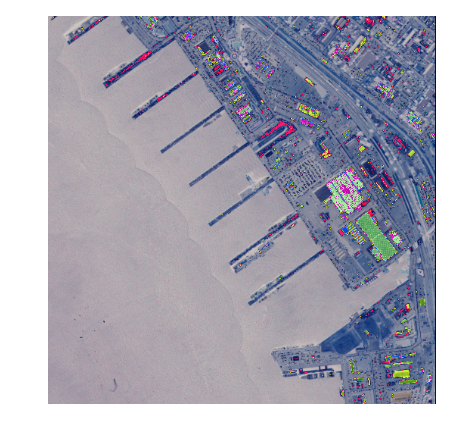

In [251]:
def stretch(rgb):
    lims = np.percentile(rgb,(2,98),axis=(0,1))
    for x in xrange(len(rgb[0,0,:])):
        top = lims[:,x][1]
        bottom = lims[:,x][0]
        rgb[:,:,x] = (rgb[:,:,x]-bottom)/float(top-bottom)
    return np.clip(rgb,0,1)
    
def render(tif, w=5, h=5):
    with rasterio.open(tif) as src:
        b, g, r = src.read([2,3,4], masked=True)

    rgb = np.dstack([r,g,b])
    print rgb.dtype
    plt.figure(figsize=(w,h))
    plt.axis('off')
    plt.grid('off')
    plt.imshow(rgb)
    plt.show() 
    

@widgets.interact(idx=widgets.IntSlider(value=0, min=0, max=len(idaho_map.merged)-1))
def show_frame(idx):
    render(idaho_map.merged[idx])

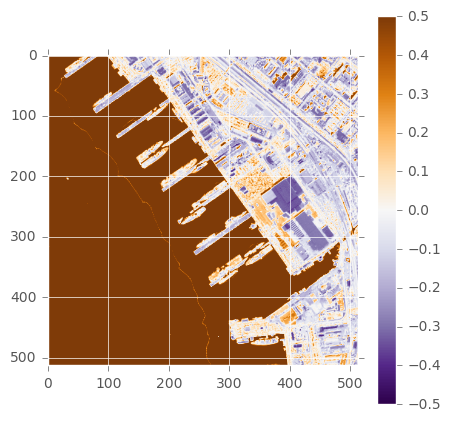

In [250]:
def compute_index(idx):
    with load_frame(idx) as bands:
        # Compute WV-BI Index (Normalized Built-up Index) 
        # http://www.harrisgeospatial.com/docs/BackgroundOtherIndices.html#WorldVie
        return (bands[COASTAL] - bands[RED_EDGE])/(bands[COASTAL] + bands[RED_EDGE])

@widgets.interact(idx=widgets.IntSlider(value=0, min=0, max=len(idaho_map.merged)-1))
def preview_index(idx):
    plt.figure(figsize=(5,5))
    plt.imshow(compute_index(idx), vmin=-0.5, vmax=0.5, cmap="PuOr_r")
    plt.colorbar()
    plt.show()

In [241]:
def stretch(rgb):
    lims = np.percentile(rgb,(2,98),axis=(0,1))
    for x in xrange(len(rgb[0,0,:])):
        top = lims[:,x][1]
        bottom = lims[:,x][0]
        rgb[:,:,x] = (rgb[:,:,x]-bottom)/float(top-bottom)
    return np.clip(rgb,0,1)
    
def render(tif, w=5, h=5):
    with rasterio.open(tif) as src:
        b, g, r = src.read([2,3,4], masked=True).astype(np.float32)

    rgb = stretch(np.dstack([r,g,b]))
    plt.figure(figsize=(w,h))
    plt.axis('off')
    plt.grid('off')
    plt.imshow(rgb)
    plt.show() 
    
def render_rgb(rgb, w=5, h=5):
    rgb = stretch(rgb)
    plt.figure(figsize=(w,h))
    plt.axis('off')
    plt.grid('off')
    plt.imshow(rgb)
    plt.show() 

In [4]:
from contextlib import contextmanager

COASTAL = 0
BLUE = 1
GREEN = 2
YELLOW = 3
RED = 4
RED_EDGE = 5
NIR1 = 6
NIR2 = 7

@contextmanager
def load_frame(idx):
    with rasterio.open(idaho_map.merged[idx]) as src:
        bands = src.read([1,2,3,4,5,6,7,8], masked=True).astype(np.float32)
        yield bands

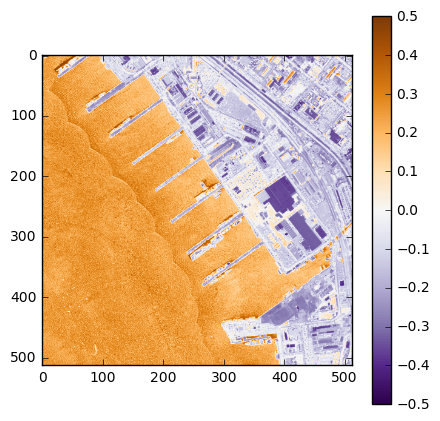

In [5]:
def compute_index(idx):
    with load_frame(idx) as bands:
        # Compute WV-BI Index (Normalized Built-up Index) 
        # http://www.harrisgeospatial.com/docs/BackgroundOtherIndices.html#WorldVie
        return (bands[COASTAL] - bands[RED_EDGE])/(bands[COASTAL] + bands[RED_EDGE])

@widgets.interact(idx=widgets.IntSlider(value=0, min=0, max=len(idaho_map.merged)-1))
def preview_index(idx):
    plt.figure(figsize=(5,5))
    plt.imshow(compute_index(idx), vmin=-0.5, vmax=0.5, cmap="PuOr_r")
    plt.colorbar()
    plt.show()

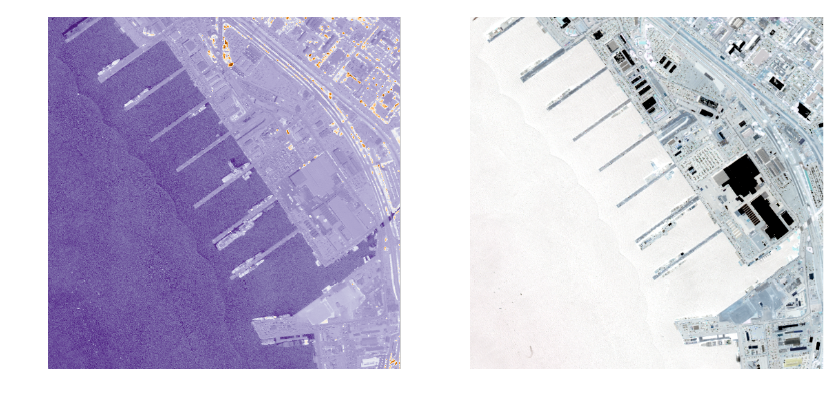

In [249]:
def create_index(tif_path, index_type):
 
    def _calculate(NIR, Red, SWIR=None, Green=None):
        if index_type == 'NDVI':
            return (NIR - Red)/(NIR + Red)
        elif index_type == 'NDWI':
            return (Green - NIR)/(Green + NIR)
        elif index_type == 'NBR':
            return  (NIR - SWIR)/(NIR + SWIR)
        else: # SAVI
            return ((NIR - Red)/(NIR + Red + 0.5)) * (1 + 0.5)
    
    with rasterio.open(tif_path) as src:
        b, g, r, nir = src.read([2,3,5,7], masked=True).astype(np.float32)
        
    index = _calculate(nir, r, Green=g) 
    rgb = stretch(np.dstack([r,g,b]))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10), facecolor='white')
    ax1.axis('off')
    ax2.axis('off')
    ax1.imshow(index, cmap="PuOr_r")
    ax2.imshow(rgb)
    plt.show() 

create_index(idaho_map.merged[0], 'NDVI')

In [252]:
clipped = []
for i in idaho_map.merged:
    with rasterio.open(i) as src:
        rgb = np.dstack(src.read([5,3,2], masked=True)).astype(np.float32)
        clipped.append(rgb)

bool


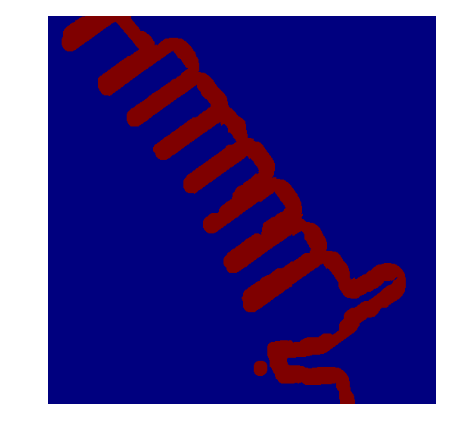

In [253]:
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def water_mask(img, thresh=0.75):
    coastal = img[:,:,0]
    nir2 = img[:,:,7]
    mask = ((coastal - nir2) / (coastal + nir2))
    return mask

def buffer_coastline(img, threshold=200):
    mask = water_mask(img) > .25
    mask = mask.astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=np.ones([3, 3]), iterations=0)
    edm1 = cv2.distanceTransform(mask, cv2.cv.CV_DIST_L2, 5)
    s = (edm1 < 10)
    mask[s] = 255
    mask[~s] = 0
    edm2 = cv2.distanceTransform(mask, cv2.cv.CV_DIST_L2, 5)
    s = (edm2 < 25) & (edm1 < 10)
    mask[s] = 255
    mask[~s] = 0
    return mask, edm1, edm2

def render_array(arr1, arr2=None, width=7, height=7, cmap=plt.cm.jet):
    if arr2 is None:
        fig, ax = plt.subplots(1, figsize=(width,height), facecolor='white')
        ax.axis('off')
        plt.imshow(arr1, cmap=cmap)
        plt.show()
    else: 
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
        fig.set_size_inches(width, height)
        ax1.imshow(arr2)
        ax1.axis('off')
        ax2.imshow(arr1)
        ax2.axis('off')
                          
# with rasterio.open(idaho_map.merged[-1]) as src:
#     img = np.dstack(src.read(masked=True)).astype(np.float32)
#     mask, edm1, edm2 = buffer_coastline(img.copy())
#     render_array(edm1, edm2, width=5, height=5)
#     render_array(mask, width=4, height=4)
    
masks = []
for image in idaho_map.merged:
    with rasterio.open(image) as src:
        img = np.dstack(src.read(masked=True)).astype(np.float32)
        mask, edm1, edm2 = buffer_coastline(img, threshold=175)
        #render_array(edm1, edm2, width=4, height=4)
        #render_array(mask, width=4, height=4)
        masks.append(mask)
    
union_mask = reduce( lambda s,e: s * e, masks )
#union_mask = cv2.dilate(union_mask, kernel=np.ones([3, 3]), iterations=3)
binary_mask = union_mask.copy().astype(np.bool)
print binary_mask.dtype
#binary_mask[(union_mask > 0)] = 1
render_array(binary_mask, width=5, height=5)


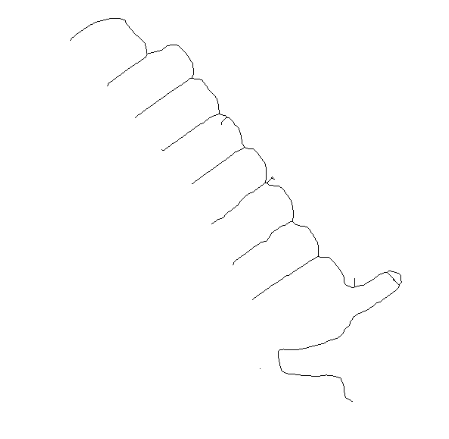

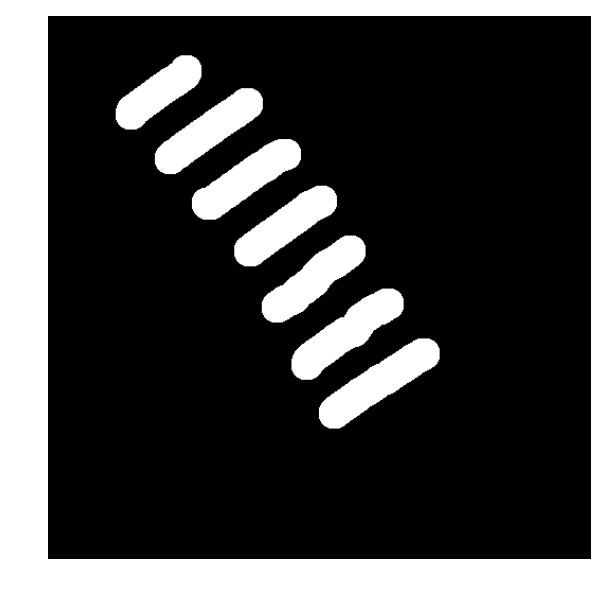

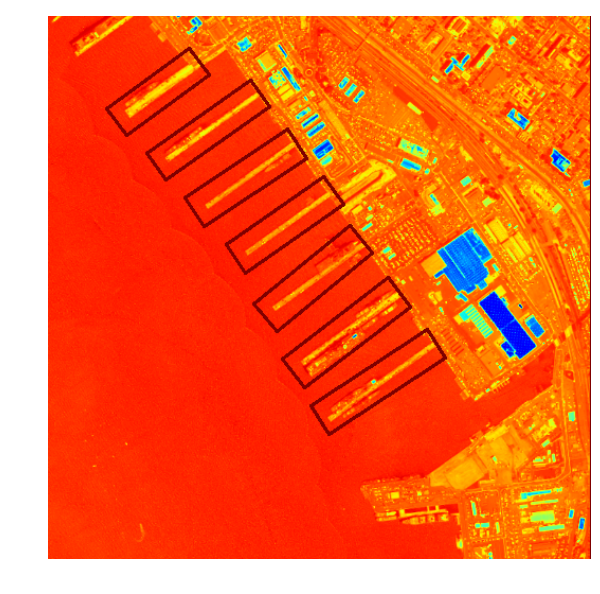

In [264]:
import numpy as np
import cv2

from skimage import measure
from skimage.measure import regionprops
from skimage.morphology import skeletonize, convex_hull_image, medial_axis, opening
from scipy import ndimage

def stretch(rgb):
    lims = np.percentile(rgb,(2,98),axis=(0,1))
    for x in xrange(len(rgb[0,0,:])):
        top = lims[:,x][1]
        bottom = lims[:,x][0]
        rgb[:,:,x] = (rgb[:,:,x]-bottom)/float(top-bottom)
    return np.clip(rgb,0,1)

def seg_buffer(im, dist=25):
    mask = im.copy()
    edm1 = cv2.distanceTransform(~im, cv2.cv.CV_DIST_L2, 5)
    s = (edm1 < dist)
    mask[s] = 1
    return mask, edm1

skel = skeletonize(binary_mask).astype(np.int)
render_array(~skel, width=5, height=5, cmap=plt.cm.gray)

k = np.array([[1,1,1],[1,0,1],[1,1,1]])
ngrid = ndimage.convolve(skel, k, mode='constant') * skel
ngrid[ngrid > 2] = 0
ngrid[(ngrid <= 2) & (ngrid > 0)] = 1

segment_labels = measure.label(ngrid)
segment_props = measure.regionprops(segment_labels)

i=0
buffers = []
for seg in segment_props:
    i += 1
    if (seg.major_axis_length < 75.0 or seg.orientation < 0 
        or seg.orientation > 1.1 
        or seg.solidity < 0.09):
        continue

    buff, edm1 = seg_buffer((segment_labels == i).astype(np.uint8) * 255, dist=15)
    buffers.append(buff)

buffer_sum = reduce( lambda s,e: s + e, buffers )

contours, hierarchy = cv2.findContours( buffer_sum.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
vis = clipped[0].copy()

regions = []
for i, cnt in enumerate(contours):
    if cv2.contourArea(cnt) > 0.0:
        rect = cv2.minAreaRect(cnt)
        box = cv2.cv.BoxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(vis,[box],0,(0,0,0),2)
        regions.append({ 'box': box, 'rect': rect, 'bounds': cv2.boundingRect(cnt)})

render_array(buffer_sum, cmap=plt.cm.gray)
render_array(vis[:,:,1])

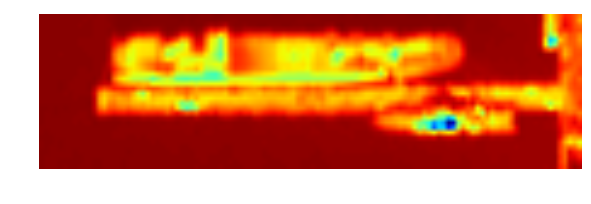

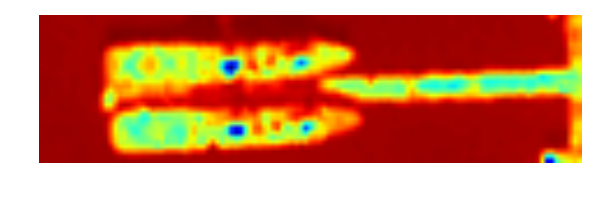

In [265]:
def crop_region(region, img):
    with rasterio.open(img) as src:
        bands = np.dstack(src.read(masked=True))
        rect = region['rect']
        center = rect[0]
        angle = rect[2]
        size = rect[1]
        size = (int(size[0]), int(size[1]))
     
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        warped = cv2.warpAffine(bands, M, dsize=bands[:,:,0].shape, flags=cv2.INTER_CUBIC)
        crop = np.ndarray((size[1],size[0],8))
        
        for i in xrange(8):
            crop[:,:,i] = cv2.getRectSubPix(warped[:,:,i].astype(np.float32), size, center)

        return crop.astype(np.float32)

image_regions = [[crop_region(region, img) for region in regions[1:]] for img in idaho_map.merged]
render_array(image_regions[2][2][:,:,0])
render_array(image_regions[1][3][:,:,1])

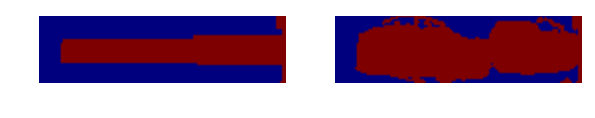

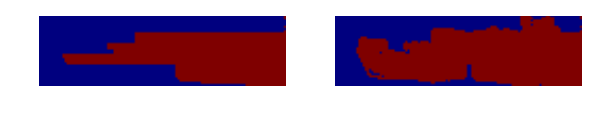

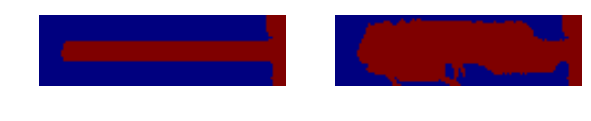

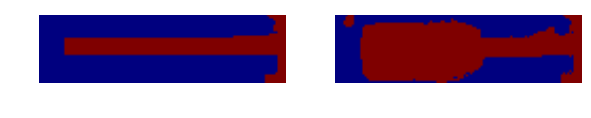

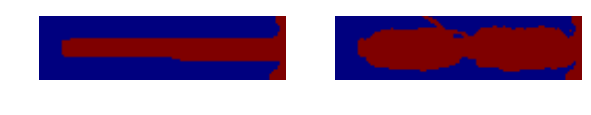

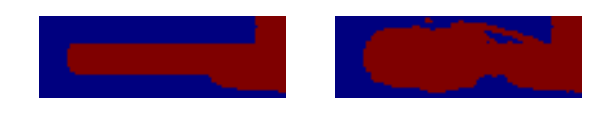

In [262]:
def water_mask(img,  thresh=0.75):
    coastal = img[:,:,0]
    nir2 = img[:,:,7]
    mask = ((coastal - nir2) / (coastal + nir2))
    return mask

def scanline_mask(imask):
    mask = np.ndarray(imask.shape)

    for l in xrange(imask.shape[0]):
        line = imask[l,:]
        labels = measure.label(line)
        land = labels[-1]
        if land == 1:
            mask[l,:] = labels
        else:
            labels[ labels != land ] = 0
            labels[ labels > 0 ] = 1
            mask[l,:] = labels

    return (mask >= 1).astype(np.uint8)


region_masks_all = []
region_masks = []

for r in xrange(len(image_regions[0])):
    _masks = []
    for i in xrange(1, len(image_regions)):
        img = image_regions[i][r].copy()
        mask = water_mask(img)
        #print mask.dtype
        _masks.append( 1 - mask )
        
    region_masks_all.append(_masks)
    r_mask = reduce( lambda s,e: s + e, [m > 0.25 for m in _masks])
    sl_mask = scanline_mask(r_mask)
    render_array(r_mask, sl_mask)
    
    region_masks.append(sl_mask)

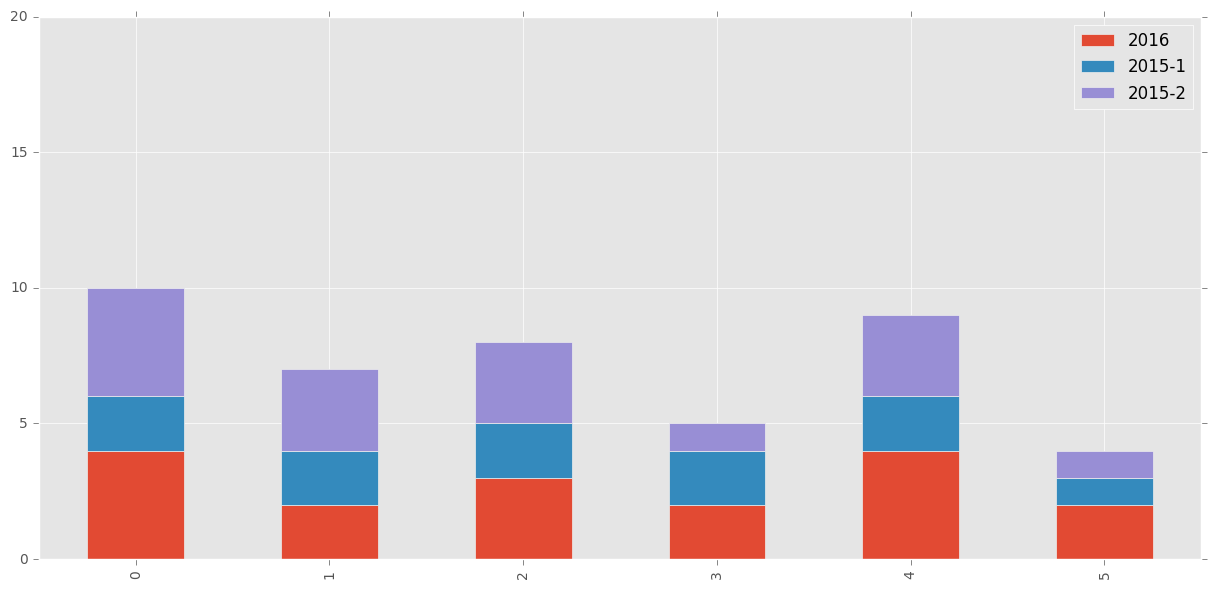

In [248]:
import cv2
from skimage.morphology import binary_opening

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline


def show_region(r):
    print 'Region:', r
    counts = []
    for i, image in enumerate(image_regions): 
        objects = found_objects[i][r]
        print 'image:', i, 'Objects:', objects['count']
        counts.append(objects['count'])
        vis = image[r].copy()
        for cnt in objects['contours']:
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(vis,(x,y),(x+w,y+h),(255,0,0),1)
        render_array(vis, width=6, height=6)    


def find_objects(r, r_img, show=False):
    vis = np.dstack([r_img[:,:,4], r_img[:,:,2], r_img[:,:,1]])
    t_mask = 1 - (water_mask( r_img ) > .75)
    mask = region_masks[r].copy()
    diff = mask - t_mask
    diff[ diff > 0 ] = 0
    
    diff = binary_opening(diff).astype(np.uint8)
    #render_array(diff)
    
    labels = measure.label(diff)
    props = measure.regionprops(labels)
    contours, hierarchy = cv2.findContours(diff.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    filter_contours = []
    areas = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 20.0: 
            areas.append(area)
            filter_contours.append(cnt)
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(vis,(x,y),(x+w,y+h),(255,0,0),1)
            #cv2.drawContours(vis, cnt, -1, (255,0,0), 2)
            
    return filter_contours, areas
    
    
found_objects = []
for i in xrange(1, len(image_regions)):
    regions = image_regions[i]
    region_objs = []
    for r in xrange(0, len(regions)):
        img = regions[r]
        contours, areas = find_objects(r, img.copy())
        cnt = len(contours)
        region_objs.append({'areas': areas, 'contours': contours, 'count': cnt})
    found_objects.append(region_objs) 
    

cnts = [[o['count'] for o in img] for img in found_objects]

#print cnts
df2 = pd.DataFrame(np.array(cnts).transpose(), columns=['2016', '2015-1', '2015-2'])
df2.plot.bar(figsize=(15, 7), width=.5, ylim=(0,20), stacked=True)
plt.show()
#show_region(3)


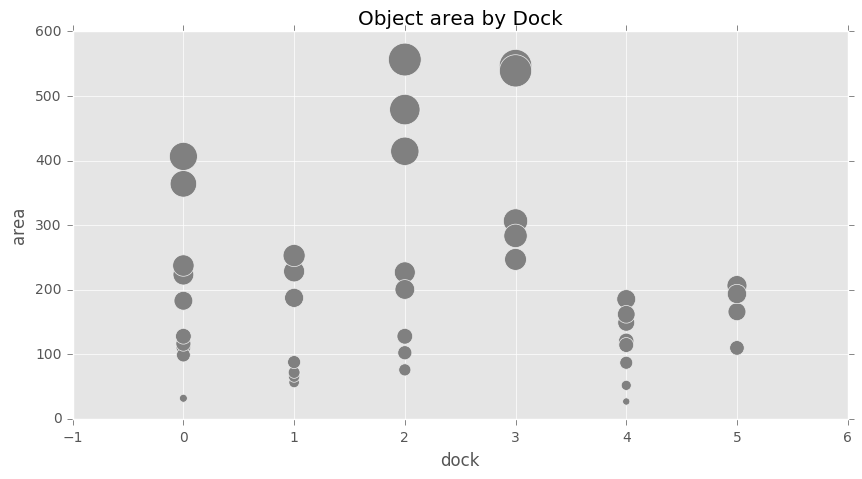

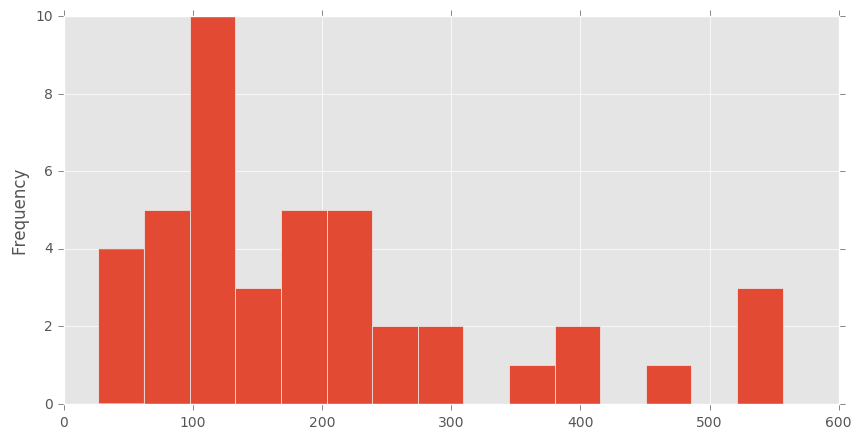

In [267]:
import pandas as pd

areas = []
for i, img in enumerate(found_objects):
    for r, reg in enumerate(img):
        for cnt in reg['contours']:
            areas.append((cv2.contourArea(cnt), r, i))
            
df = pd.DataFrame(data = areas, columns=['area', 'dock', 'image'])

df.plot(kind='scatter', x='dock', y='area', figsize=(10, 5), c='gray', s=df['area'], ylim=(0,600), title="Object area by Dock")
#df.plot(kind='scatter', x='image', y='area', figsize=(10, 5), s=75)
#df.plot(kind='scatter', x='dock', y='image', figsize=(10, 5), s=df['area'])

plt.figure();
df['area'].plot(kind='hist', bins=15, figsize=(10, 5), x='Area')
plt.show()